In [1]:
# !conda install tqdm -y

In [2]:
# !pip install seaborn

In [3]:
import os
import ast
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
# !pip install sktime

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [6]:
from tsai.all import *

In [7]:
my_setup()

os              : Linux-5.14.0-503.11.1.el9_5.x86_64-x86_64-with-glibc2.34
python          : 3.12.8
tsai            : 0.4.1
fastai          : 2.8.2
fastcore        : 1.8.2
torch           : 2.5.1+cu124
device          : 2 gpus (['NVIDIA A10', 'NVIDIA A10'])
cpu cores       : 32
threads per cpu : 1
RAM             : 250.85 GB
GPU memory      : [22.49, 22.49, 22.49, 22.49] GB


In [8]:
def extend_df(
        df: pd.DataFrame, 
        target_size: int
    ) -> pd.DataFrame:

    current_size = len(df)
    last_row = df.iloc[[-1]]
    repeats = target_size - current_size
    extension = pd.concat([last_row] * repeats, ignore_index=True)
    extension.index = range(current_size, target_size)
    
    return pd.concat([df, extension])

In [9]:
df_meta = pd.read_csv('../../sensor_fusion/df_meta_withJSON_withTimes_goodDetections_min2700.csv', index_col=0)

In [10]:
df_meta.head()

,study_id,premature,gestational_age_weeks,post_menstrual_age_days,adjusted_age_weeks,chronological_age_weeks,over3m,sex,diagnosis,y_true,...,dirname_json,start_time1,stop_time1,start_time2,stop_time2,num_frames_mkv,num_frames_json,num_frames_diff,num_scaled_snippets,fnames_scaled_snippets
0,592,0,38,294.0,40,4,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/592-aafcb787-M-28-2010221627,2700,5400,-1,-1,7196,7197,1,2,"['592-aafcb787-M-28-2010221627_df_scaled_snippet_idx0.csv', '592-aafcb787-M-28-2010221627_df_scaled_snippet_idx1.csv']"
1,1838,0,40,330.0,47,7,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/1838-1976fc8e-M-44-2010271018,3450,6150,-1,-1,7202,7203,1,2,"['1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx0.csv', '1838-1976fc8e-M-44-2010271018_df_scaled_snippet_idx1.csv']"
2,8015,0,39,314.0,43,5,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8015-d6a22f17-M-39-2010291126,1500,4200,-1,-1,7196,7197,1,2,"['8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx0.csv', '8015-d6a22f17-M-39-2010291126_df_scaled_snippet_idx1.csv']"
3,8026,0,40,488.0,69,29,1,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/8026-0e213ab6-M-207-2010301654,960,3660,-1,-1,7196,7197,1,2,"['8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx0.csv', '8026-0e213ab6-M-207-2010301654_df_scaled_snippet_idx1.csv']"
4,24034,0,37,339.0,45,11,0,1,Normal,0,...,../../sensor_fusion/pred_results_AE5K/24034-15d9bab8-M-76-2011051205_M,3690,6390,-1,-1,7196,7197,1,2,"['24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx0.csv', '24034-15d9bab8-M-76-2011051205_M_df_scaled_snippet_idx1.csv']"


In [11]:
# df_meta.shape

In [12]:
df_meta_Normal = df_meta[df_meta['diagnosis']=='Normal']
df_meta_CP     = df_meta[df_meta['diagnosis']=='CP']

In [13]:
# df_meta_Normal.shape, df_meta_CP.shape

In [14]:
df_meta_CP_train, df_meta_CP_test = train_test_split(
    df_meta_CP, test_size=0.25
)

In [15]:
num_snippets_CP_train = int(df_meta_CP_train['num_scaled_snippets'].sum())

In [16]:
num_snippets_CP_test  = int(df_meta_CP_test['num_scaled_snippets'].sum())

In [17]:
num_snippets_CP_train, num_snippets_CP_test

(64, 23)

In [18]:
dfs_combined_CP_train = []

for i in tqdm( range( len(df_meta_CP_train) ) ):

    row = df_meta_CP_train.iloc[i]
    
    dirname_json = row['dirname_json']
    
    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_CP_train.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_CP_train.append( dfs_combined_extended )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.99it/s]


In [19]:
# len(dfs_combined_CP_train)

In [20]:
# df_meta_CP[ df_meta_CP['over3m']==0 ]['num_scaled_snippets'].sum()

In [21]:
# df_meta_CP[ df_meta_CP['over3m']==1 ]['num_scaled_snippets'].sum()

In [22]:
dfs_combined_CP_test = []

for i in tqdm( range( len(df_meta_CP_test) ) ):

    row = df_meta_CP_test.iloc[i]
    
    dirname_json = row['dirname_json']

    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for j, fname in enumerate(fnames_scaled_snippets_full[:]):

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_CP_test.append( dfs_combined )
            
        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_CP_test.append( dfs_combined_extended )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.19it/s]


In [23]:
len(dfs_combined_CP_test)

23

In [24]:
dfs_combined_Normal = []

for _, row in df_meta_Normal.sample( 
        num_snippets_CP_train + num_snippets_CP_test,
    ).iterrows():

    dirname_json = row['dirname_json']
    
    fnames_scaled_snippets_tmp  = ast.literal_eval( row['fnames_scaled_snippets'] )
    fnames_scaled_snippets_full = [ os.path.join( dirname_json, fname ) for fname in fnames_scaled_snippets_tmp ]

    for fname in fnames_scaled_snippets_full[:1]:

        fname_asterisk = fname.replace('.csv', '_*.csv')
        
        fnames_dfs = glob.glob( fname_asterisk )

        dfs = []
        for fname_df in fnames_dfs:
            df = pd.read_csv(fname_df, index_col=0)
            dfs.append(df)

        dfs_combined = pd.concat( dfs, axis=1 )
    
        if len(dfs_combined)==2700:
            dfs_combined_Normal.append( dfs_combined )

        elif (len(dfs_combined) < 2700) & (len(dfs_combined) > 2680):
            dfs_combined_extended = extend_df( dfs_combined, 2700 )
            dfs_combined_Normal.append( dfs_combined_extended )

In [25]:
dfs_combined_Normal_train = dfs_combined_Normal[:len(dfs_combined_CP_train)]

In [26]:
dfs_combined_Normal_test  = dfs_combined_Normal[len(dfs_combined_CP_train):]

In [27]:
# len(dfs_combined_Normal_train), len(dfs_combined_Normal_test)

In [28]:
dfs_combined_train = dfs_combined_CP_train + dfs_combined_Normal_train

In [29]:
dfs_combined_test  = dfs_combined_CP_test + dfs_combined_Normal_test

In [30]:
# len(dfs_combined_train), len(dfs_combined_test)

In [31]:
### BREAK HERE ####

In [32]:
X_train = []
for dfs_combined in dfs_combined_train:
    X_train.append( dfs_combined.values )

In [33]:
y_train = [1] * len(dfs_combined_CP_train) + [0] * len(dfs_combined_Normal_train)

In [34]:
y_train_arr = np.asarray(y_train)

In [35]:
X_test = []
for dfs_combined in dfs_combined_test:
    X_test.append( dfs_combined.values )

In [36]:
y_test = [1] * len(dfs_combined_CP_test) + [0] * len(dfs_combined_Normal_test)

In [37]:
y_test_arr = np.asarray(y_test)

In [38]:
# len(y_train_arr), len(y_test_arr)

In [39]:
X_train_arr = np.asarray(X_train).transpose( (0,2,1 ) )

In [40]:
X_test_arr  = np.asarray(X_test).transpose( (0,2,1 ) )

In [41]:
# X_train_arr.shape, X_test_arr.shape

In [ ]:
### QUESTION FOR NCH ###

In [42]:
lms_using4 = [
    'left_wrist','right_wrist','left_ankle','right_ankle'
]

In [43]:
lms_using8 = [
    'left_wrist','right_wrist','left_ankle','right_ankle',
    'left_shoulder','right_shoulder','left_hip','right_hip'
]

In [44]:
lms_using12 = [
    'left_wrist','right_wrist','left_ankle','right_ankle',
    'left_shoulder','right_shoulder','left_hip','right_hip',
    'left_elbow','right_elbow','left_knee','right_knee'
]

In [62]:
#### CHANGE THIS ####
lms_using = lms_using4

In [63]:
# Decide which columns/features to use

In [64]:
feature_sets = set( [col.split('__')[0] for col in dfs_combined.columns] )

In [65]:
feature_sets

{'lm2dists_centroid_2d',
 'lm2dists_centroid_3d',
 'lm2dists_framewise_2d',
 'lm2dists_framewise_3d',
 'lm_pair2dists_2d',
 'lm_pair2dists_3d',
 'lm_triple2angles',
 'polar_coords',
 'pos_2d',
 'pos_3d'}

In [66]:
feature_set2col_indices = {}
for feature_set in feature_sets:
    
    print(f'feature_set={feature_set}')
    
    col_indices = []
    for i, col in enumerate(dfs_combined.columns):
        if feature_set in col:
            if feature_set not in ['lm_triple2angles', 'lm_pair2dists_2d', 'lm_pair2dists_3d', 'polar_coords']:
                lm = '_'.join( col.split('__')[-1].split('_')[:-1] )
                # print(i, feature_set, col, lm)
                if lm in lms_using:
                    col_indices.append(i)
            else:
               col_indices.append(i) 

    feature_set2col_indices[feature_set] = col_indices
    # print('***')

feature_set=lm_pair2dists_2d
feature_set=lm2dists_framewise_3d
feature_set=pos_3d
feature_set=lm2dists_framewise_2d
feature_set=lm_triple2angles
feature_set=lm_pair2dists_3d
feature_set=lm2dists_centroid_3d
feature_set=pos_2d
feature_set=polar_coords
feature_set=lm2dists_centroid_2d


In [67]:
feature_sets_2d = [
    'pos_2d',
    'lm2dists_framewise_2d',
    'lm2dists_centroid_2d',
    'lm_pair2dists_2d',
    'lm_triple2angles',
    'polar_coords'
]

In [68]:
feature_sets_3d = [
    'pos_3d',
    'lm2dists_framewise_3d',
    'lm2dists_centroid_3d',
    'lm_pair2dists_3d',
    'lm_triple2angles',
    'polar_coords'
]

In [69]:
# feature_set2col_indices

In [70]:
col_indices = []
# for feature_set in feature_sets_2d:
# for feature_set in feature_sets_3d:
for feature_set in ['pos_3d','lm_pair2dists_3d']:
    col_indices_tmp = feature_set2col_indices[feature_set]
    for col_idx in col_indices_tmp:
        col_indices.append(col_idx)

In [71]:
len( col_indices )

24

In [72]:
#### MAKE SURE OK WITH NCH ####

In [73]:
skip = 5

In [74]:
X_train_arr_smaller = X_train_arr[:,col_indices,::skip]
# X_train_arr_smaller = X_train_arr[:,:,::skip]
# X_train_arr_smaller = X_train_arr[:,col_indices,:]
# X_train_arr_smaller = X_train_arr[:,:,:]

In [75]:
X_test_arr_smaller = X_test_arr[:,col_indices,::skip]
# X_test_arr_smaller = X_test_arr[:,:,::skip]
# X_test_arr_smaller = X_test_arr[:,col_indices,:]
# X_test_arr_smaller = X_test_arr[:,:,:]

In [76]:
X_train_arr_smaller.shape, X_test_arr_smaller.shape

((128, 24, 540), (46, 24, 540))

In [77]:
# X_train_arr_smaller_cumsum = np.cumsum(X_train_arr_smaller, axis=-1)

In [78]:
# X_test_arr_smaller_cumsum = np.cumsum(X_test_arr_smaller, axis=-1)

In [79]:
# X_train_arr_smaller_cumsum.shape, X_test_arr_smaller_cumsum.shape

In [80]:
X_tsai, y_tsai, splits = combine_split_data(
    [X_train_arr_smaller, X_test_arr_smaller], [y_train_arr, y_test_arr]
    # [X_train_arr_smaller_cumsum, X_test_arr_smaller_cumsum], [y_train_arr, y_test_arr]
)

In [81]:
len(X_tsai)

174

In [82]:
bs = 16
n_epochs = 150

In [83]:
tfms  = [
    [None], 
    [Categorize()]
]
batch_tfms = [TSStandardize()]

In [84]:
dsets = TSDatasets(X_tsai, y_tsai, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=batch_tfms)

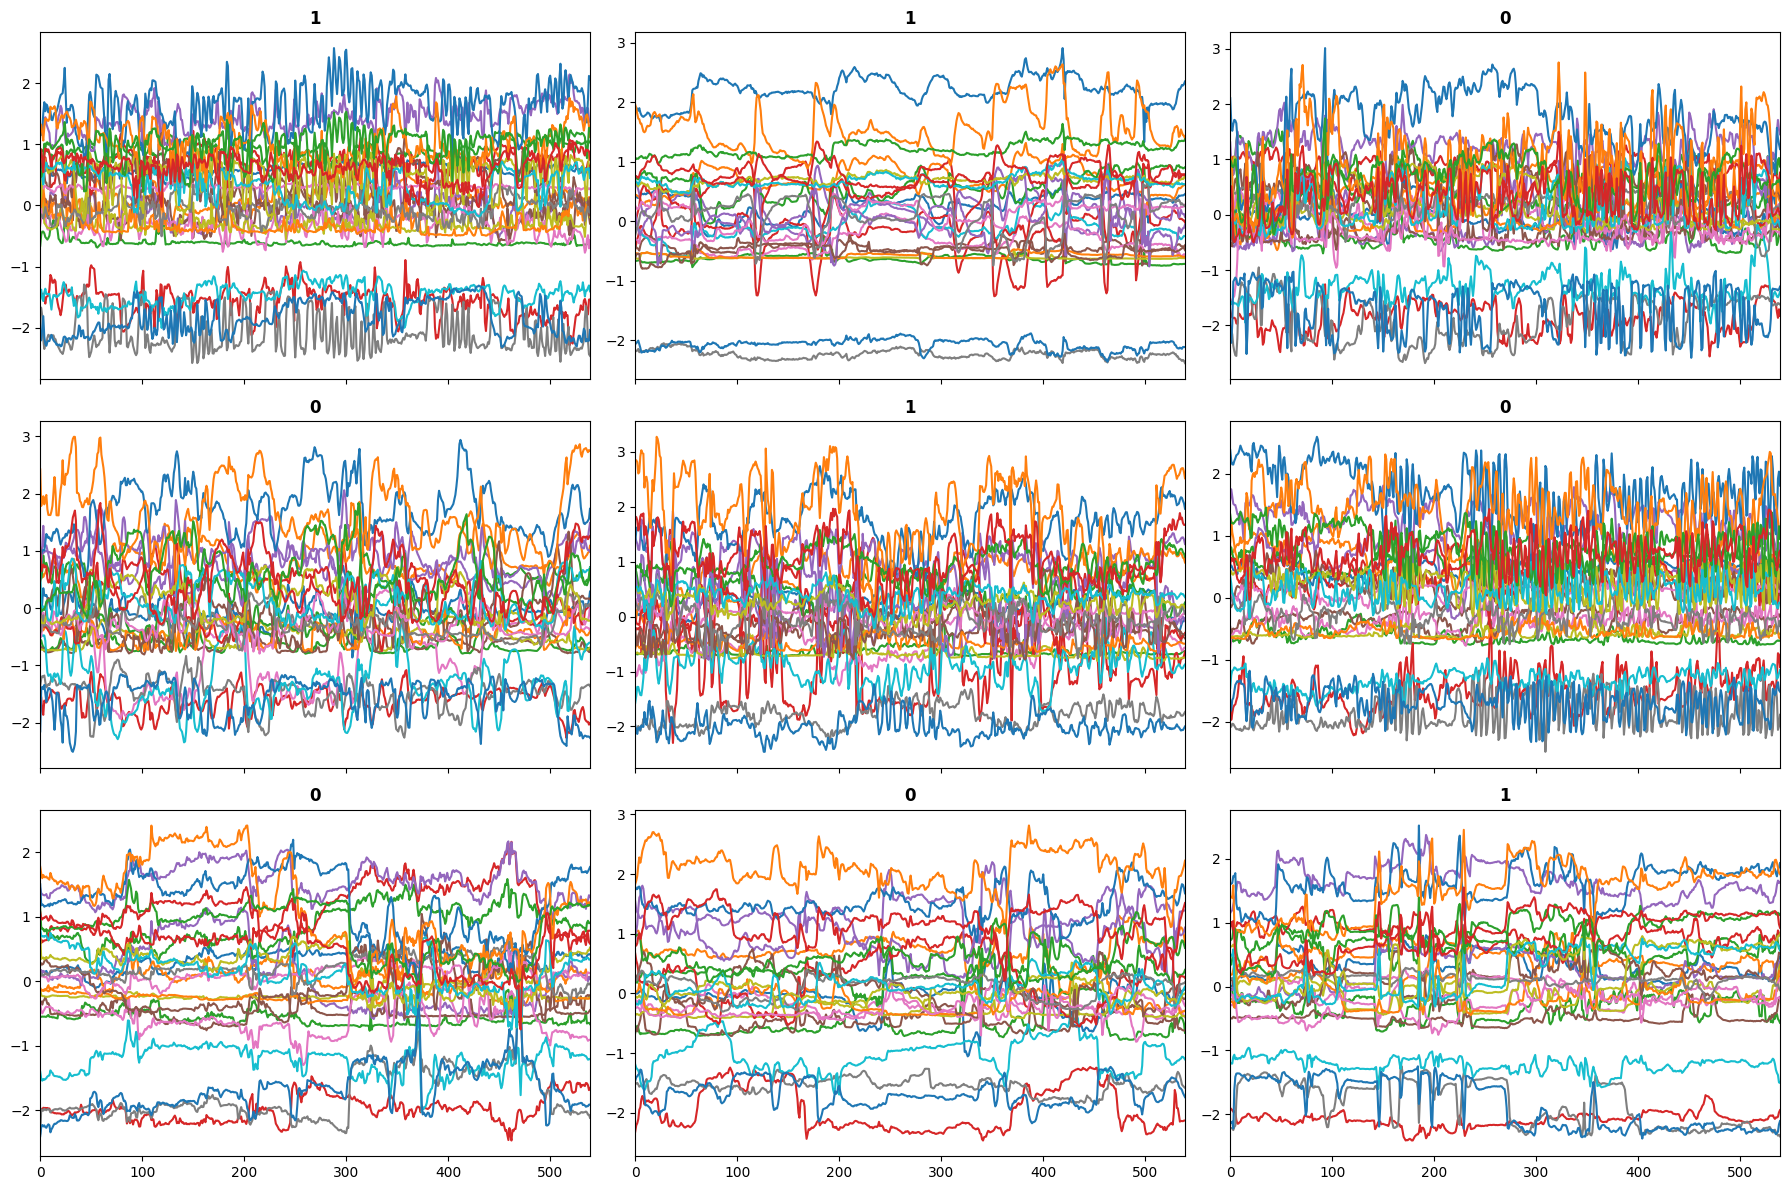

In [85]:
dls.show_batch()

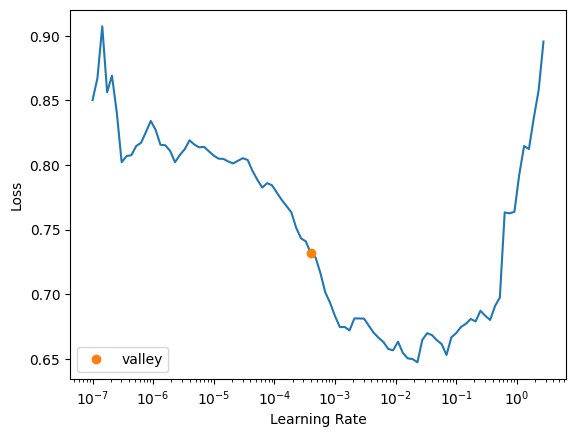

In [86]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, 
                metrics=[RocAucBinary(), accuracy, Precision(), F1Score()], 
                cbs=ShowGraphCallback2())
lr_max = learn.lr_find()[0]

In [87]:
lr_max

0.0003981071640737355

epoch,train_loss,valid_loss,roc_auc_score,accuracy,precision_score,f1_score,time
0,0.796109,0.689202,0.655955,0.565217,0.714286,0.333333,00:00
1,0.769460,0.696920,0.550095,0.521739,0.555556,0.312500,00:00
2,0.738425,0.705582,0.514178,0.478261,0.428571,0.200000,00:00
3,0.713983,0.708461,0.531191,0.478261,0.428571,0.200000,00:00
4,0.682973,0.715482,0.551985,0.543478,0.666667,0.275862,00:00
5,0.655436,0.726479,0.550095,0.565217,0.666667,0.375000,00:00
6,0.624474,0.750813,0.529301,0.565217,0.615385,0.444444,00:00
7,0.591036,0.806999,0.519849,0.478261,0.444444,0.250000,00:00
8,0.557618,0.903042,0.470699,0.543478,0.583333,0.400000,00:00
9,0.524029,1.004178,0.463138,0.456522,0.400000,0.242424,00:00


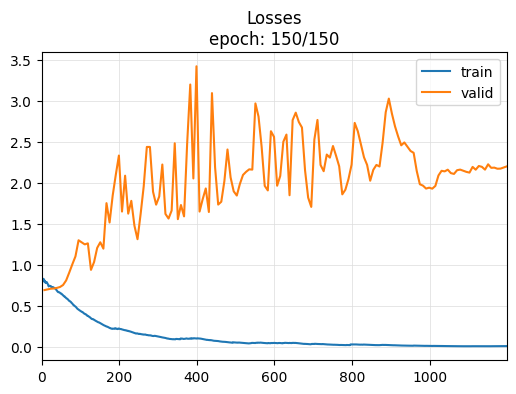

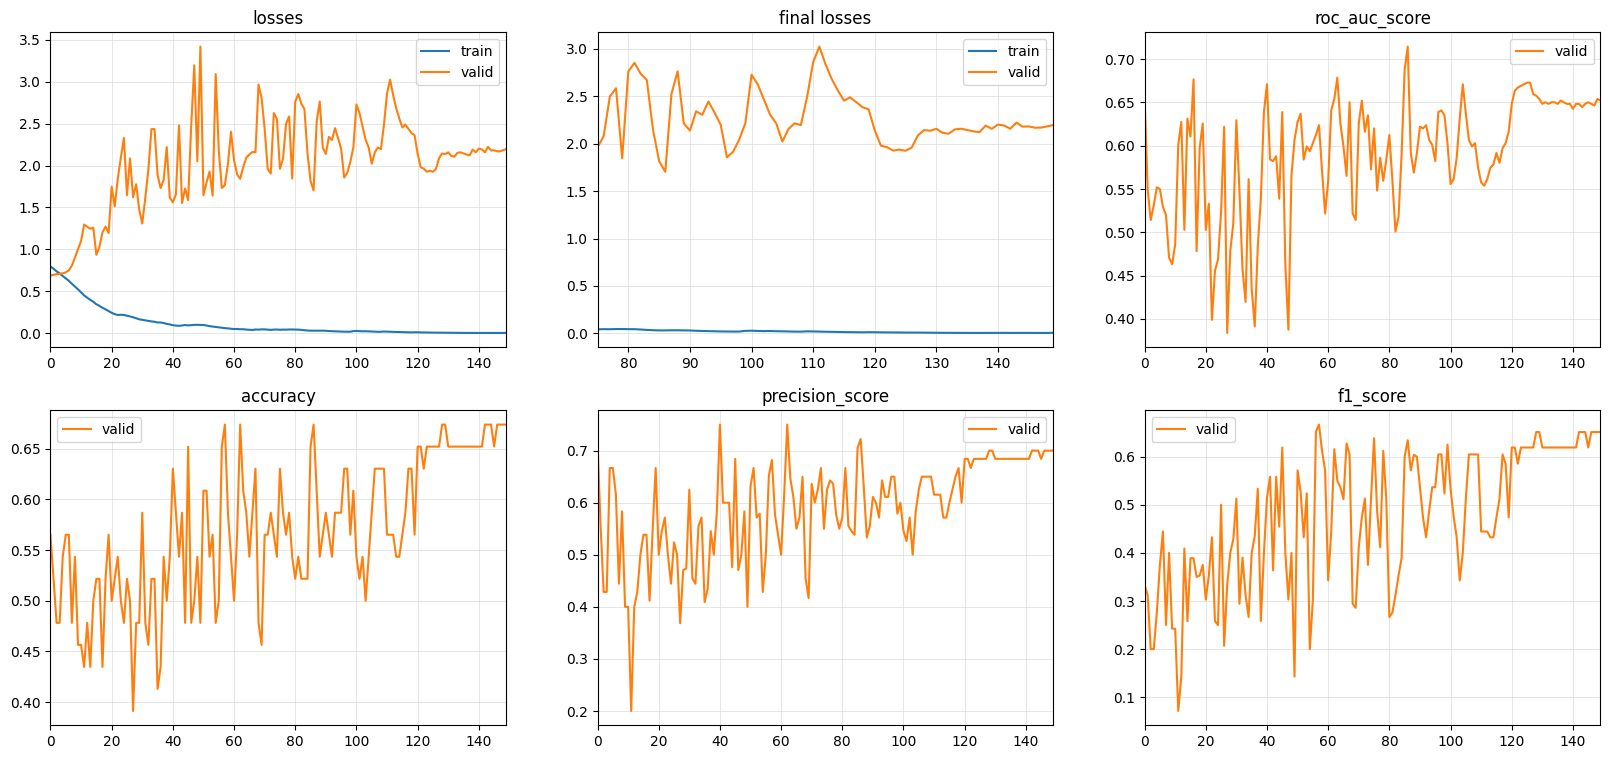


Elapsed time: 35.710283041000366


In [88]:
start = time.time()
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
print('\nElapsed time:', time.time() - start)